In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

train_data = pd.read_csv(r'/content/drive/MyDrive/Pós IA/Séries temporais /T2/DailyDelhiClimateTrain.csv')
test_data = pd.read_csv(r'/content/drive/MyDrive/Pós IA/Séries temporais /T2/DailyDelhiClimateTest.csv')

data = pd.concat([train_data[:-1], test_data], ignore_index=True)
data.sort_values(by='date', inplace=True)

##Para esse exercício vamos usar o Dataset "Daily Climate time series data" com o histórico climático da cidade de Delhi de 2013 a 2017, com as informações de temperatura média, humidade, velocidade do vento e pressão média do vento, será construída uma rede para a previsão da variável de temperatura média.

In [36]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [37]:
data.dtypes

,0
date,object
meantemp,float64
humidity,float64
wind_speed,float64
meanpressure,float64


In [38]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1575.000000,1575.000000,1575.000000,1575.000000
mean,25.231582,60.420115,6.903642,1010.589745
std,7.337316,16.956083,4.508803,175.298310
min,6.000000,13.428571,0.000000,-3.041667
25%,18.516667,49.750000,3.700000,1001.875000
50%,27.166667,62.380952,6.370000,1009.000000
75%,31.142857,72.125000,9.262500,1015.183333
max,38.714286,98.000000,42.220000,7679.333333


In [39]:
nulos = data.isnull().sum()

print(f"""\nQuantidade de valores nulos: \n{nulos}""")


Quantidade de valores nulos: 
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


O dataset não apresenta valores nulos, não apresenta oscilações além da normalidade e possui tipos padronizados.

In [40]:
data.shape

(1575, 5)

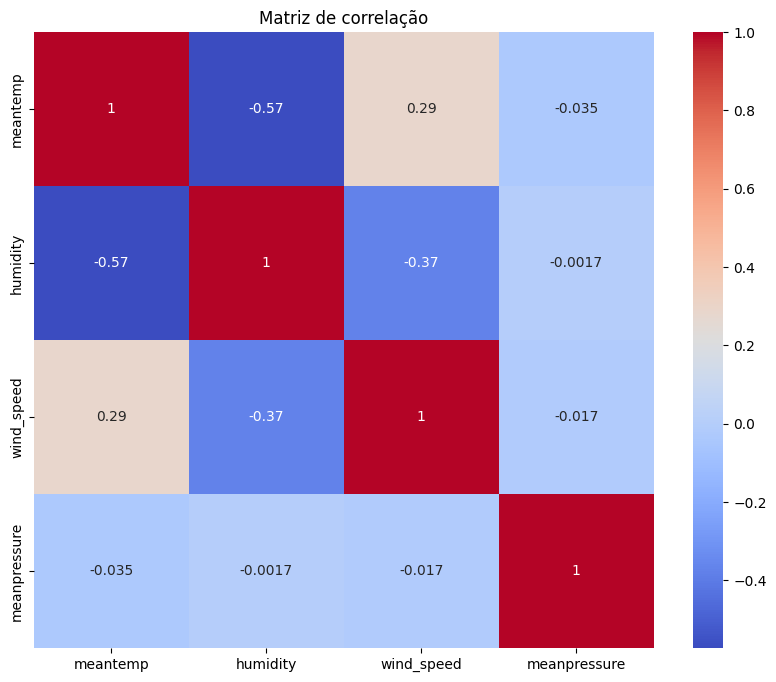

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(data[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()

Pela matriz de correlação, nenhuma variável parece ser redundante.

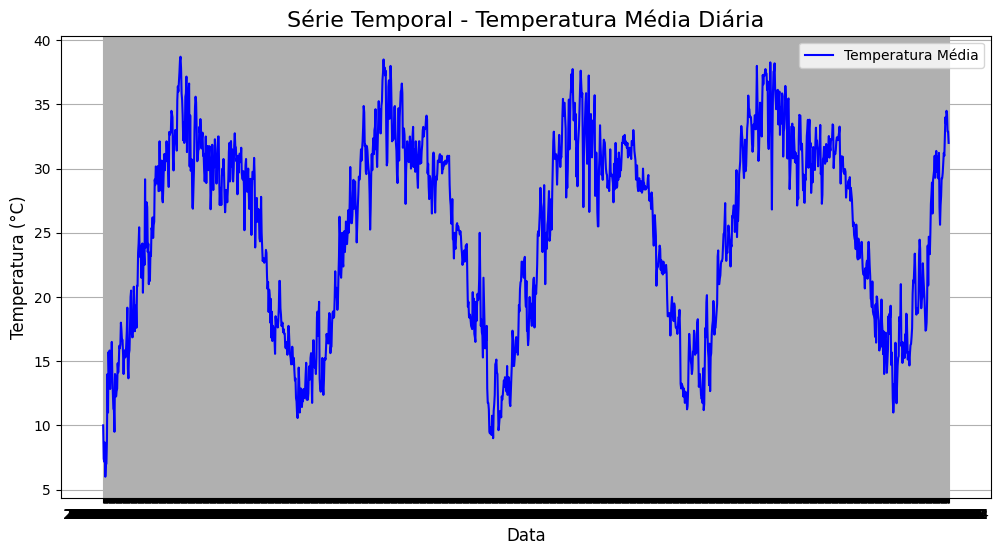

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['meantemp'], label='Temperatura Média', color='blue')
plt.title('Série Temporal - Temperatura Média Diária', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

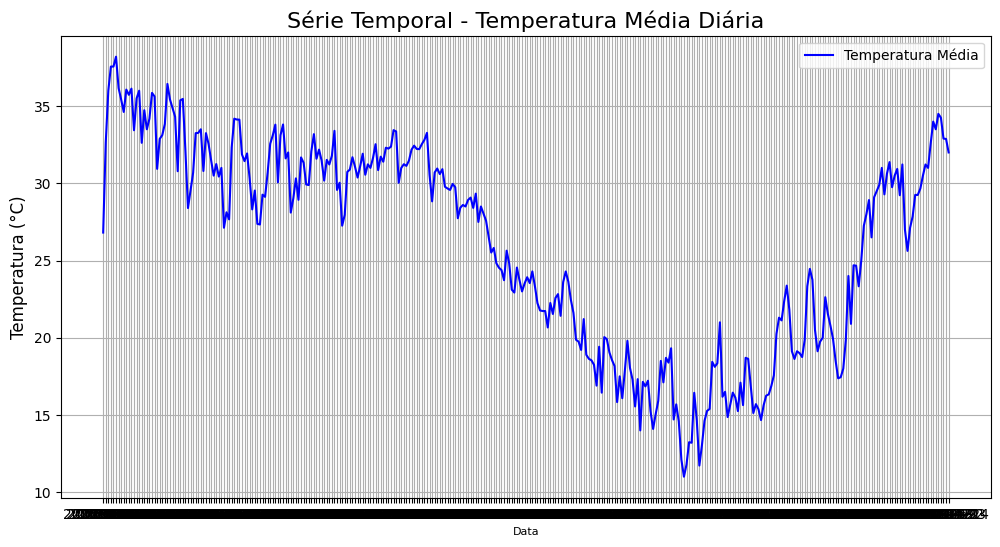

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(data.tail(330)['date'], data.tail(330)['meantemp'], label='Temperatura Média', color='blue')
plt.title('Série Temporal - Temperatura Média Diária', fontsize=16)
plt.xlabel('Data', fontsize=8)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

Podemos observar sazonalidades de acordo com as estações do ano no hemisfério norte.

Vamos normalizar os dados das variáveis que serão usadas na previsão:

In [44]:
from sklearn.preprocessing import MinMaxScaler
import joblib

features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
scaler = MinMaxScaler()

norm_data = pd.DataFrame()
norm_data[features] = scaler.fit_transform(data[features])

joblib.dump(scaler, '/content/drive/MyDrive/Pós IA/Séries temporais /T2/scaler.pkl')

norm_data['date'] = data['date']
norm_data = norm_data[['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]

In [45]:
norm_data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,0.122271,0.840372,0.000000,0.132603
1,2013-01-02,0.042795,0.929054,0.070583,0.132881
2,2013-01-03,0.035662,0.869932,0.109743,0.132994
3,2013-01-04,0.081514,0.684685,0.029212,0.132799
4,2013-01-05,0.000000,0.867962,0.087636,0.132712


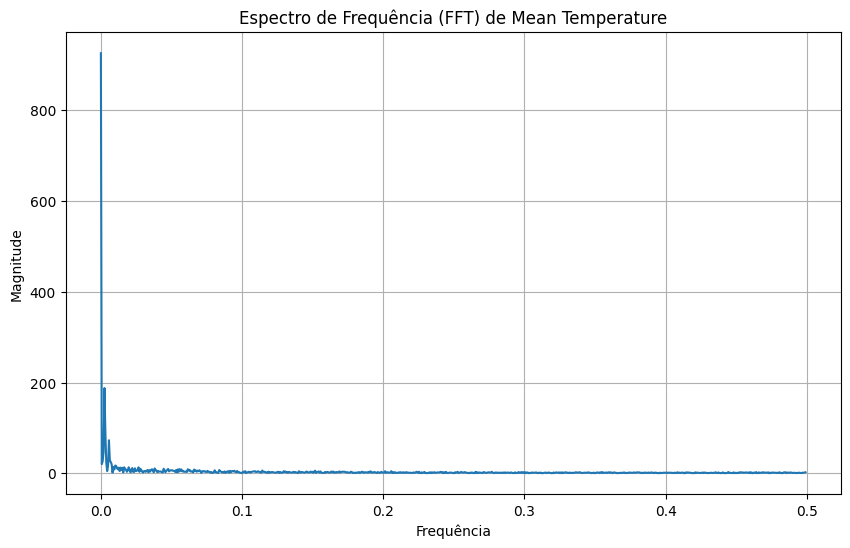

Frequência dominante (ciclo por dia): 0.0
Período da frequência dominante: inf dias


<ipython-input-46-1aab71d50419>:24: RuntimeWarning: divide by zero encountered in scalar divide
  period = 1 / dominant_frequency


In [46]:
data_fft = norm_data['meantemp'].dropna()

fft_result = np.fft.fft(data_fft)

frequencies = np.fft.fftfreq(len(data_fft))

# Magnitude das frequências
magnitude = np.abs(fft_result)

# Plotar as magnitudes das frequências
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:len(frequencies)//2], magnitude[:len(magnitude)//2]) # Apenas metade positiva
plt.title('Espectro de Frequência (FFT) de Mean Temperature')
plt.xlabel('Frequência')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

# Identificar picos de frequência
dominant_frequency = frequencies[np.argmax(magnitude[:len(magnitude)//2])]
print(f"Frequência dominante (ciclo por dia): {dominant_frequency}")

# Frequência de retorno para valores diários
period = 1 / dominant_frequency
print(f"Período da frequência dominante: {period} dias")

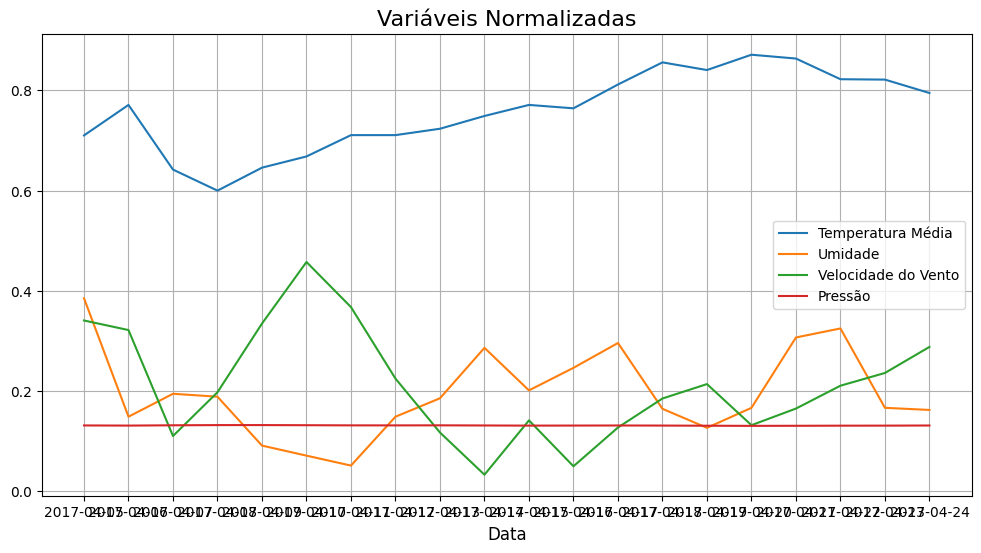

In [47]:
# Plotar a série temporal para a temperatura média (ou outra variável desejada)
plt.figure(figsize=(12, 6))
plt.plot(norm_data.tail(20)['date'], norm_data.tail(20)['meantemp'], label = 'Temperatura Média')
plt.plot(norm_data.tail(20)['date'], norm_data.tail(20)['humidity'], label = 'Umidade')
plt.plot(norm_data.tail(20)['date'], norm_data.tail(20)['wind_speed'], label = 'Velocidade do Vento')
plt.plot(norm_data.tail(20)['date'], norm_data.tail(20)['meanpressure'], label = 'Pressão')

plt.title('Variáveis Normalizadas', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.legend()
plt.grid()
plt.show()

In [48]:
def window_slicer(data, target_column, feature_columns, window_size):
    X, y = [], []

    series = data[feature_columns].values
    target = data[target_column].values

    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(target[i+window_size])

    return np.array(X), np.array(y)

In [49]:
window_size = 90
feature_columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
X, y = window_slicer(norm_data, 'meantemp', feature_columns, window_size=window_size)

In [50]:
# Visualizar forma dos dados
print("Formato de X (entradas):", X.shape)  # (n_amostras, 90, 4)
print("Formato de y (alvos):", y.shape)    # (n_amostras,)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Formato de X_train:", X_train.shape)
print("Formato de y_train:", y_train.shape)
print("Formato de X_test:", X_test.shape)
print("Formato de y_test:", y_test.shape)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

Formato de X (entradas): (1485, 90, 4)
Formato de y (alvos): (1485,)
Formato de X_train: (1188, 90, 4)
Formato de y_train: (1188,)
Formato de X_test: (297, 90, 4)
Formato de y_test: (297,)


In [51]:
model_1 = Sequential()
model_1.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(Dense(1))

model_1.compile(optimizer='adam', loss='mean_squared_error')

history = model_1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred = model_1.predict(X_test)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1796 - val_loss: 0.0081
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0038 - val_loss: 0.0055
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0037 - val_l

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Erro quadrático médio (MSE): 4.1136


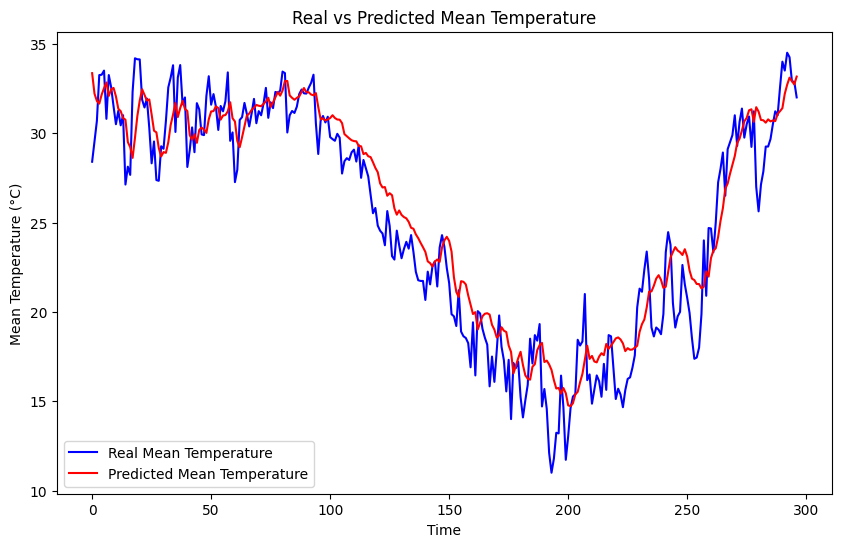

In [52]:
# 9. Reverter a normalização (opcional)
# Para reverter a normalização e visualizar os valores reais de temperatura
y_test_scaled = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test), np.zeros_like(y_test), np.zeros_like(y_test))))[:, 0]
y_pred_scaled = scaler.inverse_transform(np.column_stack((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred), np.zeros_like(y_pred))))[:, 0]

# 10. Avaliar o modelo (MSE)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"Erro quadrático médio (MSE): {mse:.4f}")

# 11. Plotar as previsões
plt.figure(figsize=(10,6))
plt.plot(y_test_scaled, color='blue', label='Real Mean Temperature')
plt.plot(y_pred_scaled, color='red', label='Predicted Mean Temperature')
plt.title('Real vs Predicted Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

In [53]:
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mean_squared_error')

history = model_2.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test), verbose=1)

y_pred = model_2.predict(X_test)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.5324 - val_loss: 0.2250
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.2017 - val_loss: 0.0302
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0353 - val_loss: 0.0662
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0567 - val_loss: 0.0299
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0234 - val_loss: 0.0128
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.0180 - val_loss: 0.0143
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - loss: 0.0187 - val_loss: 0.0112
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0130 - val_loss: 0.0087
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0086 - val_loss: 0.0099
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0053 - val_loss: 0.0055


Erro quadrático médio (MSE): 5.3691


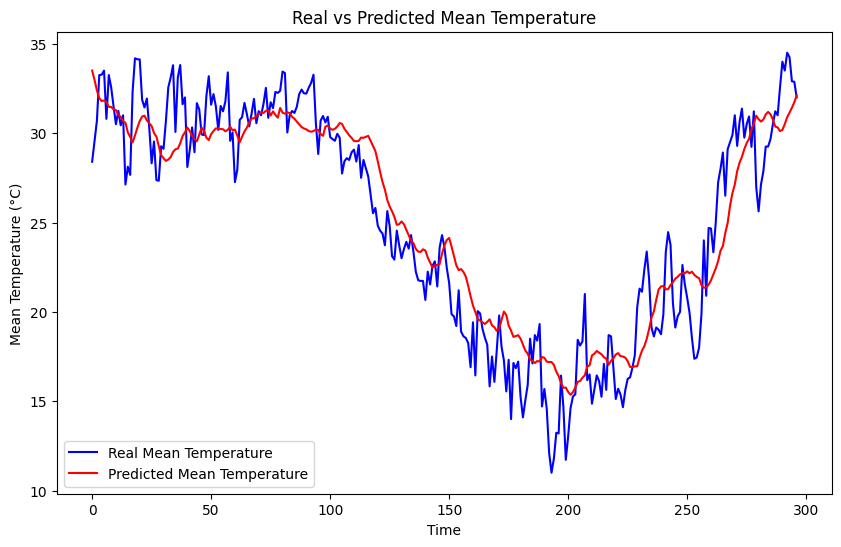

In [54]:
# 9. Reverter a normalização (opcional)
# Para reverter a normalização e visualizar os valores reais de temperatura
y_test_scaled = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test), np.zeros_like(y_test), np.zeros_like(y_test))))[:, 0]
y_pred_scaled = scaler.inverse_transform(np.column_stack((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred), np.zeros_like(y_pred))))[:, 0]

# 10. Avaliar o modelo (MSE)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"Erro quadrático médio (MSE): {mse:.4f}")

# 11. Plotar as previsões
plt.figure(figsize=(10,6))
plt.plot(y_test_scaled, color='blue', label='Real Mean Temperature')
plt.plot(y_pred_scaled, color='red', label='Predicted Mean Temperature')
plt.title('Real vs Predicted Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

In [55]:
model_3 = Sequential()
model_3.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(Dense(1))

model_3.compile(optimizer='adam', loss='mean_squared_error')

history = model_3.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

y_pred = model_3.predict(X_test)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1603 - val_loss: 0.0051
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0034 - val_l

Erro quadrático médio (MSE): 3.1700


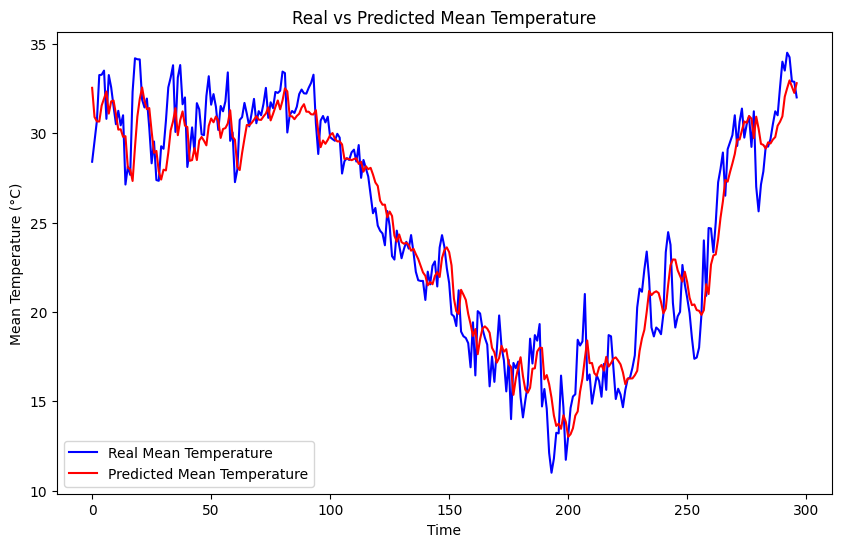

In [56]:
# 9. Reverter a normalização (opcional)
# Para reverter a normalização e visualizar os valores reais de temperatura
y_test_scaled = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test), np.zeros_like(y_test), np.zeros_like(y_test))))[:, 0]
y_pred_scaled = scaler.inverse_transform(np.column_stack((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred), np.zeros_like(y_pred))))[:, 0]

# 10. Avaliar o modelo (MSE)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"Erro quadrático médio (MSE): {mse:.4f}")

# 11. Plotar as previsões
plt.figure(figsize=(10,6))
plt.plot(y_test_scaled, color='blue', label='Real Mean Temperature')
plt.plot(y_pred_scaled, color='red', label='Predicted Mean Temperature')
plt.title('Real vs Predicted Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

In [57]:
window_size = 360
feature_columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
X, y = window_slicer(norm_data, 'meantemp', feature_columns, window_size=window_size)

In [58]:
# Visualizar forma dos dados
print("Formato de X (entradas):", X.shape)  # (n_amostras, 90, 4)
print("Formato de y (alvos):", y.shape)    # (n_amostras,)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Formato de X_train:", X_train.shape)
print("Formato de y_train:", y_train.shape)
print("Formato de X_test:", X_test.shape)
print("Formato de y_test:", y_test.shape)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

Formato de X (entradas): (1215, 360, 4)
Formato de y (alvos): (1215,)
Formato de X_train: (972, 360, 4)
Formato de y_train: (972,)
Formato de X_test: (243, 360, 4)
Formato de y_test: (243,)


In [59]:
model_4 = Sequential()
model_4.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_4.add(Dense(1))

model_4.compile(optimizer='adam', loss='mean_squared_error')

history = model_4.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

y_pred = model_4.predict(X_test)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - loss: 0.1059 - val_loss: 0.0041
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss:

Erro quadrático médio (MSE): 2.9024


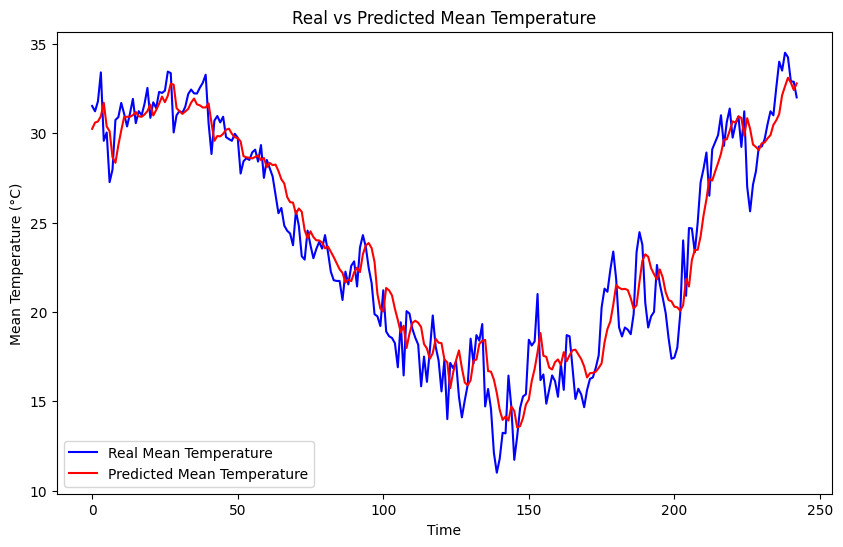

In [60]:
# 9. Reverter a normalização (opcional)
# Para reverter a normalização e visualizar os valores reais de temperatura
y_test_scaled = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test), np.zeros_like(y_test), np.zeros_like(y_test))))[:, 0]
y_pred_scaled = scaler.inverse_transform(np.column_stack((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred), np.zeros_like(y_pred))))[:, 0]

# 10. Avaliar o modelo (MSE)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"Erro quadrático médio (MSE): {mse:.4f}")

# 11. Plotar as previsões
plt.figure(figsize=(10,6))
plt.plot(y_test_scaled, color='blue', label='Real Mean Temperature')
plt.plot(y_pred_scaled, color='red', label='Predicted Mean Temperature')
plt.title('Real vs Predicted Mean Temperature')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.show()

##Usar uma janela maior no windows slicer permitiu capturar melhor as sazonalidades anuais de variação de temperatura e um número menor no tamanho dos batches capturou as oscilações de curto prazo.